In [8]:
import pandas as pd
import numpy as np

In [9]:
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
from IPython.display import HTML

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [10]:
from malaria import utils, stats
from standardiser import standardise


- Introduction
- Data
- Comparing two Chembl datasets
- Modelling on combined data
- Lipophilicity
- QED
- Fun stuff: Molport suggestions

### 1. Summary and Questions.

#### Questions:

(regarding datasets:  James, Jake, Nick? - also please show to anyone who might know answers...)

- The TCAMS dataset is really weird (see data section). Why are there so many missing activity values.
- Why are there 1068 different activity values for Chloroquine????

(regarding methodology)

- Lipophilicity.  Seems fairly clear (both from theory - see regression line) and from practice (see crazy molecules you get at the end if you select for potency - logP, that you should really select for potency - logP/12, or soemthing like that, and only within a certain range (2-4)



#### Main results 

(some of these may be well known - I don't know).  Please look through and comment which you find obvious, interesting, surprising, obviously incorrect.

All results obviously caveated on the limitations of the dataset mentioned above.

- Modelling.  

We focus on modelling potency (against 3D7 strain of _Plasmodium Falciparum_) and Toxicity (measured by percent inhibition of HEPG2 cells).  Obviously high potency and low toxicity are (among) the things we strive to attain.

We look at two machine learning algorthms - ridge regression and random forests.  The reason these two are chosen is that they are the most effective (depending on the precise specification of the insample/out-of-sample) that we found in 

On toxicity modelling, we find the following.
a) The random forest and ridge OOS performances are not too different (and better than potency on the Chembl dataset, although this might be due to the artifially low variance on the TC dataset - it is worse than the R2 for potency on the full dataset)
b) Hashed fingerprints slightly outperform standard fingerprints, although...
b) Using logP as a separate predictor increases the best model predictive power by around 5%, and when this is done, the improvement of using hashed fingerprints is barely noticeable.


- LogP/Lipophilicity.   

a) If we beli


 

- QED

a) QED and logP are highly anti-correlated.
b) logP beats QED in explaining both potency and toxicity.  In fact, logP adds value above and beyond the full fingerprint set, whereas QED does not.
c) However - when it comes to screening m

QED - introduced in the Nature paper [QED REF] is supposed to be a marker for 'being a good drug candidate'.  It takes values between [0, 1]




### 2. Introduction.

This paper is the first part of a two-paper series that looks at publically available Malaria data in the context of QSAR modelling.  In our earlier papers [REF1, REF2] we had looked at the target data for 25 different protein targets.

Here we deal with a single (non-protein - I know there is some special word for this) target.  We also look to merge

In this paper we attempt to extend work in our two earlier papers [add ref].  These papers both dealt with the problems of:
- What is the correct framework for the modelling problem faced in drug discovery?  In particular, how should the in and out-of-sample datasets be selected?
- How should we choose which machine learning algorithm should be chosen to tackle the prediction problem?


Finally - as an item of curiosity, we look at which molecules available via Molport are predicted to be active drugs against malaria.

### 2. DATA.

As mentioned in the introduction - we have two main datasets.  Firstly - the one avaliable here on chembl gitbook

A. https://chembl.gitbook.io/chembl-ntd/downloads/deposited-set-1-gsk-tcams-dataset-20th-may-2010

We will refer to this henceforth as the **TCAMS dataset**, although it is actually some combination of TCAMS and other Chembl data.  

We also have:

B. The chembl data associated to the malaria assays (downloaded from the webclient, code in Appendix)

We'll refer to this as the **Plasmodium datset**.  In this section we'll talk about the advantages and disadvantages of each dataset - and how we can use them together.

Finally we have two quite different datasets - which we will use for the purposes of sanity checking the datasets above, and testing - insofar as we can - the predictions we make from them:

C.  A list of 7 well-known malaria drugs.

D.  Roughly 7.5 million commercially available compounds from Molport.

We now describe how we construct our modelling datasets.

In [11]:
df_tcams = pd.read_pickle('parsed/chembl_tcams.pkl')
#df_plas = pd.read_pickle('parsed/chembl_plasmodium.pkl')
df_plas = pd.read_pickle('parsed/chembl_isidro.pkl')

The TCAMS data has two columns that will be of main interest to us:
- pXC50_3D7: pIC50 values against the (3D7) strain of _Plasmodium Falciparum_.  Henceforth we will refer to this value (and the similar variable available in the Plasmodium dataset) as **Potency**.
- PCT_INHIB_HEPG2: percent inhibition against HEPG2 cells, henceforth referred to as **Toxicity**.

The Plasmodium dataset only has potency values.

Both datsets have Chembl compound IDs and SMILES associated to them.  To both datasets we associate canonical smiles as calculated by our own standardiser software, to ensure uniqueness.  From these canonical smiles we then separately calculate 128 bit _binary fingerprints_ and 128 bit _hashed fingerprints_.  These will be the predictors used in the subsequent analysis.  We also use these canonical smiles to look at the uniqueness and overlap between these two datasets, which we now describe.

#### Potency, selection, uniqueness and overlap in TCAMS and Plasmodium datasets

Following list of facts about TCAMS datsets is inferred from code run below:

In [8]:
mrgd_df = pd.merge(df_plas.groupby('SMILESIS').mean(), 
                   df_tcams.groupby('SMILESIS').mean(), left_index=True, right_index=True)

tcams_good_pot = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['pXC50_3D7'].values))
tcams_good_tox = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].values))

print('TCAMS rows                              %d' % df_tcams.shape[0])
print('TCAMS unique Canonical smiles:          %d' % np.unique(df_tcams.SMILESIS.values).shape[0])
print('TCAMS unique CS with value for potency  %d' % tcams_good_pot)
print('TCAMS unique CS with value for toxicity %d' % tcams_good_tox)
print('')
print('PLASM rows                              %d' % df_plas.shape[0])
print('PLASM unique CS (all have potency val)  %d' % np.unique(df_plas.SMILESIS.values).shape[0])
print('')
print('Number unique CS in TCAMS AND PLASM     %d' % mrgd_df.shape[0])
print('')
print('Regression of POT on intersection TCAMS/PLASM')
# Halleluiah!  We can pretend they are the same!!!
gd = ~np.isnan(mrgd_df.pXC50_3D7.values)
stats.regress(mrgd_df.VAL.values[gd], [mrgd_df.pXC50_3D7.values[gd],])

TCAMS rows                              26784
TCAMS unique Canonical smiles:          21005
TCAMS unique CS with value for potency  13327
TCAMS unique CS with value for toxicity 13237

PLASM rows                              23864
PLASM unique CS (all have potency val)  18162

Number unique CS in TCAMS AND PLASM     13090

Regression of POT on intersection TCAMS/PLASM
Coeffs:       1.0004 
R-squared:    0.9749


In [9]:
figsize(20, 10)

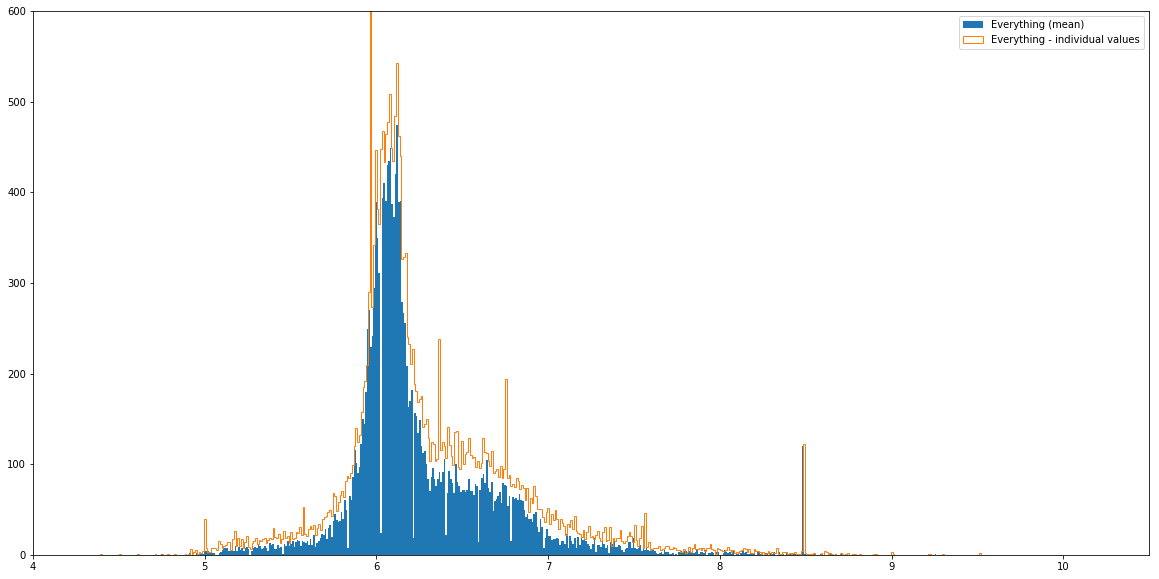

In [10]:
pyplot.hist(df_plas.groupby('SMILESIS').mean()['VAL'].values, bins=500, label='Everything (mean)')
pyplot.hist(df_plas.VAL.values, bins=500, histtype='step', label='Everything - individual values')
pyplot.legend(loc='upper right')
pyplot.ylim(top=600)
pyplot.xlim((4, 10.5))
pyplot.show()

We take mean values for potency, and we do see that the PLASM dataset and TCAMS are consistent.  In order to study potency therefore we concatenate the datasets, and take the mean values for activity by canonical smile. We refer to this dataset hencforth as **MERGED** dataset.

In [12]:
#gd = ~np.isnan(df_tcams.pXC50_3D7.values)
#full_df = pd.DataFrame.from_dict({'SMILESIS' : list(df_plas.SMILESIS.values) + list(df_tcams.SMILESIS.values[gd]), 
#                                 'POTENCY'  : list(df_plas.VAL.values) + list(df_tcams.pXC50_3D7.values[gd]),
#                                 })
#full_df = full_df.groupby('SMILESIS').mean()
#fps = [utils.get_fp(x) for x in full_df.index]
#full_df['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=full_df.index)
#hfps = [utils.get_fp(x, hashed=True) for x in full_df.index]
#full_df['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=full_df.index)
#crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#full_df['crippen'] = crippen
#full_df['qed'] = qed
#full_df.to_pickle('joined_chembl_data.pkl')
full_df = pd.read_pickle('joined_chembl_data.pkl')

We should make some further comments about the potency data before going any further.

In the TCAMS dataset, there are no values for potency below ~ 5.3.  This might lead one to think that any missing potency data is inactive.  However - this would be a bad assumption.  We checked for the best current known anti-malarial drugs (described in the next section).  All of these bar one (Doxycycline) are in the TCAMS dataset, **however**, **only two** have non-nan potency values (Chloroquine has two) - and the most potent known drug, Artemisinin has no potency value assigned.

Therefore it is clear that adding data to the TCAMS dataset is going to be necessary, but given its biases, our overall dataset will still be heavily biased, and in particularly very strongly biased towards predicting potency values that are unreasonably high.

Below we show the potency histogram of our full merged dataset:

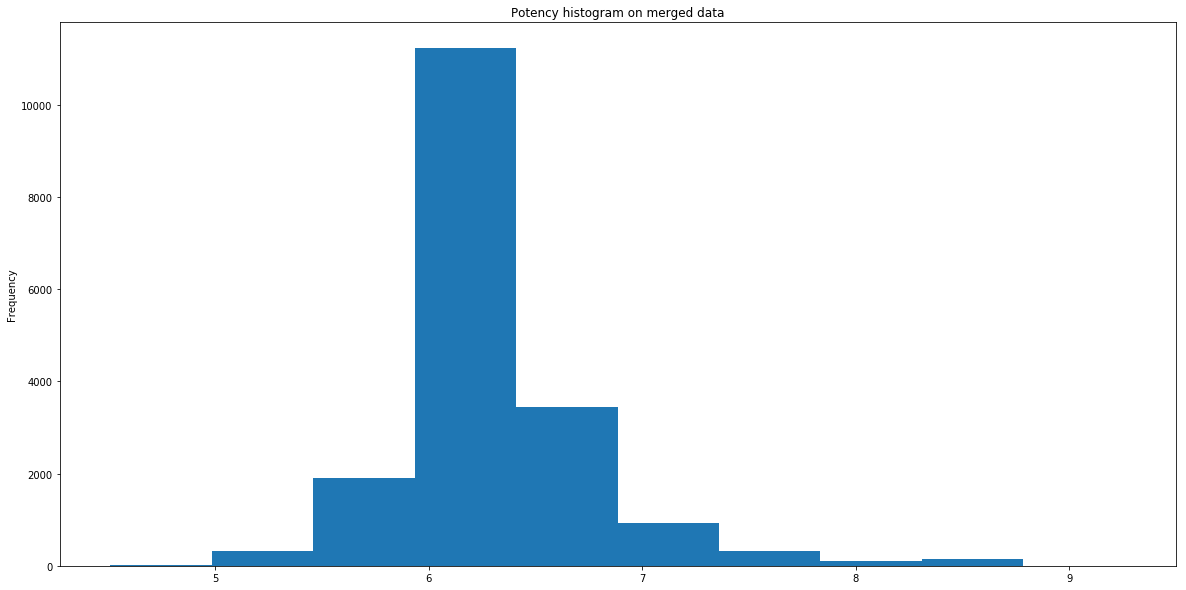

In [17]:
full_df.POTENCY.plot.hist()
_ = plt.title('Potency histogram on merged data')

Our other focus will be toxicity modelling - and here we use TCAMS data.

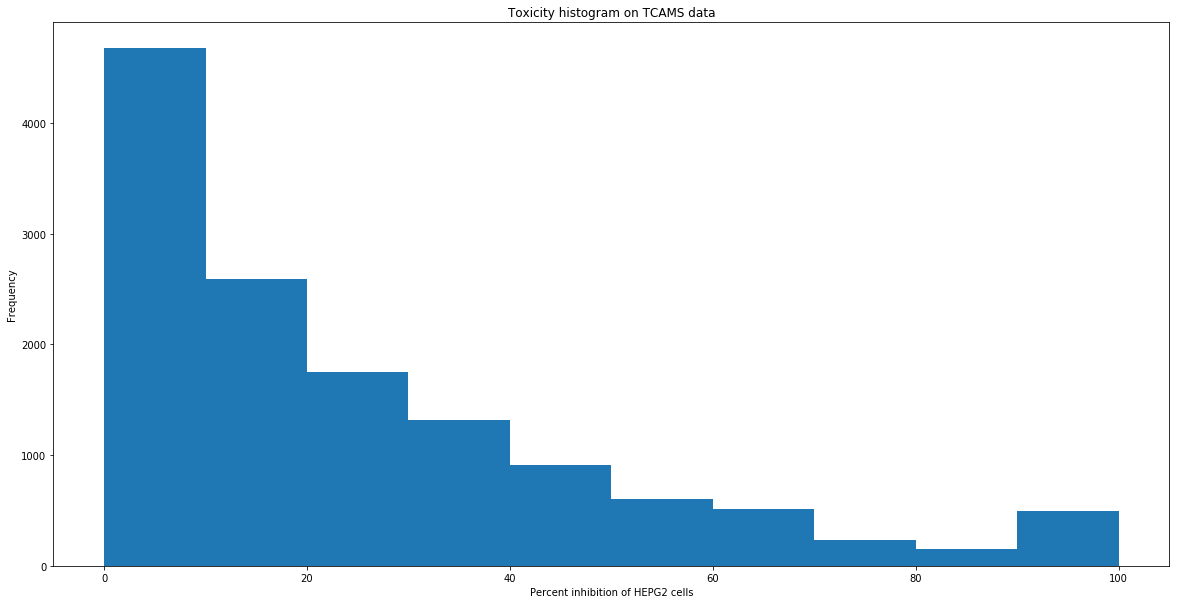

In [18]:
df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].plot.hist()
plt.xlabel('Percent inhibition of HEPG2 cells')
_ = plt.title('Toxicity histogram on TCAMS data')

#### Seven well-known Malaria drugs...

As a sanity check on our data, we will look at 7 well-known Malaria drugs, which we plot below...

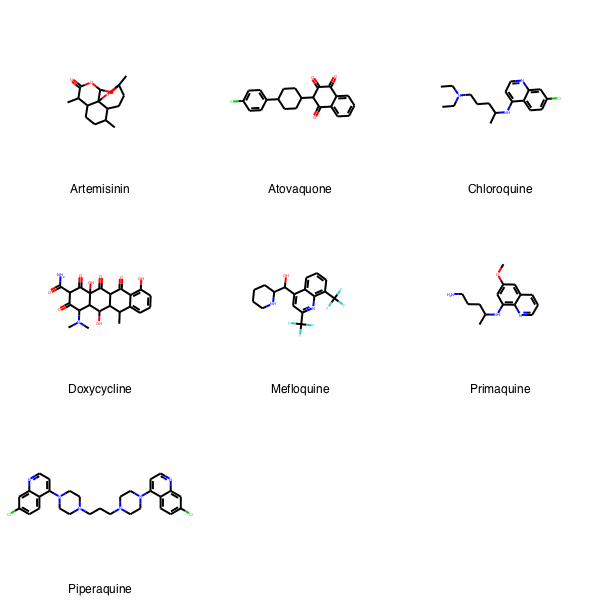

In [354]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'
Piperaquine = 'C1CN(CCN1CCCN2CCN(CC2)C3=C4C=CC(=CC4=NC=C3)Cl)C5=C6C=CC(=CC6=NC=C5)Cl'
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine, Piperaquine]
drugs = [standardise.run(drug) for drug in drugs]
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 
               'Doxycycline', 'Mefloquine', 'Primaquine', 'Piperaquine']

Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=drug_labels)

As mentioned earlier, all but Doxycycline are included in the TCAMS dataset, but we lack information on potency and toxicity for all drugs apart from Chloroquine and Mefloquine.  This is remedied by merging with the PLAS dataset, and we now only miss two drugs - Atovaquone and Doxycycline.

In [20]:
df_drug = pd.DataFrame.from_dict({'name' : drug_labels, 'SMILESIS' : drugs})
pd.merge(df_drug, full_df, left_on='SMILESIS', right_index=True)[['name', 'POTENCY']]

,name,POTENCY
0,Artemisinin,8.130000
2,Chloroquine,7.436294
4,Mefloquine,7.498105
5,Primaquine,5.615000


### 3. Modelling.

We will only report the main modelling results we obtained. In particular - we will at 'naive' in/out-of-sample testing, having done nothing but remove duplicates in order to force our two sets to be distinct.  More in-depth testing of these models - and better estimates of their domain of applicability and true out-of-sample performance will be left to the next paper.

First let us look at the performance of our two algorithms, modelling potency, using binary and hashed fingerprints.

The run below, which shows bootstrapped OOS performance of ridge and random forest algorithms, on binary and hashed fingerprints gives us the following results.

- Random forests substantially outperform ridge - and do slightly better on binary fingerprints.  The overall R2 is quite good at around ~ 41%.

In [21]:
stats.run_suite(full_df, 'POTENCY')

('Analyzing', 'POTENCY')
Beta:             1.000 [   0.998    1.002] ridge
R2 (signed):      0.110 [   0.095    0.125] at 5pct conf
Beta:             0.999 [   0.997    1.000] rf
R2 (signed):      0.307 [   0.281    0.332] at 5pct conf

Hashed...
Beta:             1.000 [   0.998    1.002] ridge
R2 (signed):      0.105 [   0.090    0.118] at 5pct conf
Beta:             1.000 [   0.998    1.001] rf
R2 (signed):      0.284 [   0.261    0.302] at 5pct conf




We now analyze toxicity models using the TCAMS data.  Again we find that random forests substantially outperform ridge - and this time using hashed fingerprints is slightly better.  The main result though is that adding logP as a predictor improves the model (extra 2% of R2).  This isn't the case for adding QED as a predictor (not shown).

In [22]:
# Add all the data to the Tcams no dups...
#df_tcams_nd = df_tcams.groupby('SMILESIS').mean()
#fps = [get_fp(x, hashed=True) for x in df_tcams_nd.index]
#df_tcams_nd['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=df_tcams_nd.index)
#hfps = [get_fp(x, hashed=True) for x in df_tcams_nd.index]
#df_tcams_nd['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=df_tcams_nd.index)
#crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in df_tcams_nd.index], index=df_tcams_nd.index)
#qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in df_tcams_nd.index], index=df_tcams_nd.index)
#df_tcams_nd['crippen'] = crippen
#df_tcams_nd['qed'] = qed
#df_tcams_nd.to_pickle('parsed/tcams_nodups.pkl')

In [348]:
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')

In [24]:
stats.run_suite(df_tcams_nd, 'PCT_INHIB_HEPG2')

('Analyzing', 'PCT_INHIB_HEPG2')
Beta:             0.986 [   0.961    1.014] ridge
R2 (signed):      0.125 [   0.117    0.133] at 5pct conf
Beta:             1.016 [   0.987    1.040] rf
R2 (signed):      0.298 [   0.281    0.310] at 5pct conf

Hashed...
Beta:             0.983 [   0.961    1.010] ridge
R2 (signed):      0.186 [   0.171    0.202] at 5pct conf
Beta:             1.029 [   1.002    1.059] rf
R2 (signed):      0.314 [   0.294    0.330] at 5pct conf




... and if we add an extra predictor of logP

In [25]:
stats.run_suite(df_tcams_nd, 'PCT_INHIB_HEPG2', add_pred=df_tcams_nd.crippen.values[:,None])

('Analyzing', 'PCT_INHIB_HEPG2')
Beta:             0.985 [   0.955    1.013] ridge
R2 (signed):      0.158 [   0.145    0.169] at 5pct conf
Beta:             1.010 [   0.982    1.033] rf
R2 (signed):      0.322 [   0.305    0.336] at 5pct conf

Hashed...
Beta:             0.980 [   0.954    1.007] ridge
R2 (signed):      0.186 [   0.168    0.202] at 5pct conf
Beta:             1.027 [   1.005    1.052] rf
R2 (signed):      0.334 [   0.315    0.358] at 5pct conf




### 4.  Lipophilicity


There is this thing called Lipophilicity.  It may matter.  
https://www.ncbi.nlm.nih.gov/pubmed/22823020.
https://www.ncbi.nlm.nih.gov/pubmed/22992175

Layman's introduction:
https://www.sciencedirect.com/topics/pharmacology-toxicology-and-pharmaceutical-science/lipophilicity

So the idea is that your target is really not pIC50 but rather pIC50 - logP.  That's because **(is it???)** there is some association between potency and logP.

On our full dataset - there is definitely an association.  Roughly an increase by 12 in logP (crippen) raises potency by one order of magnitude.  Note that unlike in the case of toxicity, adding logP as a predictor doesn't improve potency forecasting.

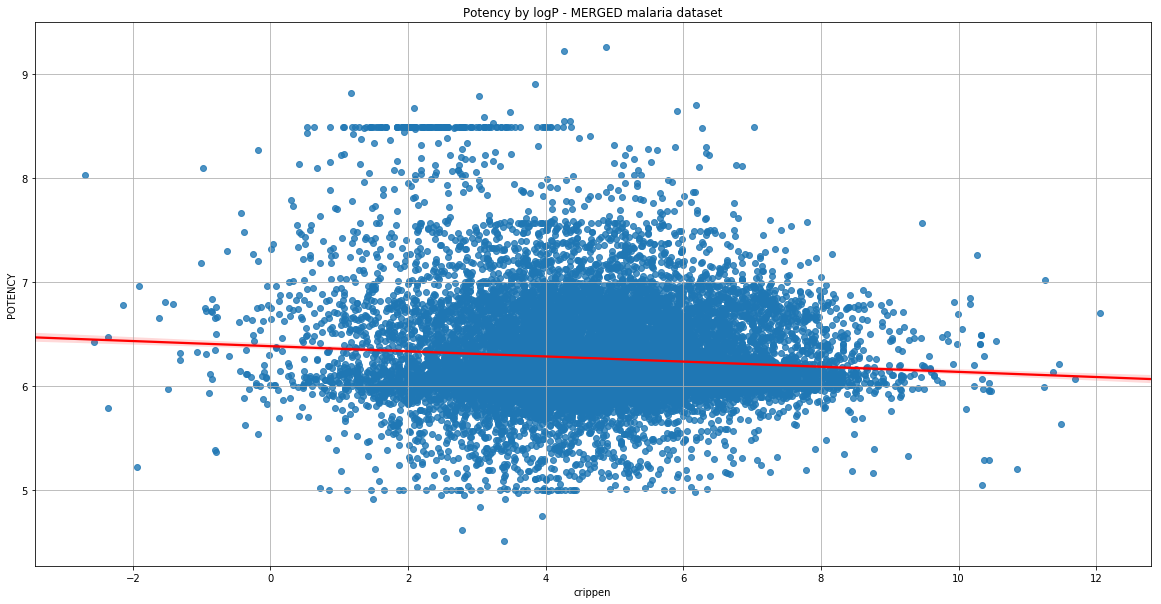

In [26]:
import seaborn as sns
sns.regplot(x='crippen',y='POTENCY',data=full_df,fit_reg=True, line_kws={'color' : 'red'})
_ = plt.title('Potency by logP - MERGED malaria dataset')
plt.grid(True)

In [27]:
pd.merge(df_drug, full_df, left_on='SMILESIS', right_index=True)[['name', 'POTENCY']]

,name,POTENCY
0,Artemisinin,8.130000
2,Chloroquine,7.436294
4,Mefloquine,7.498105
5,Primaquine,5.615000


If you believe the plot above - and view the improvement in potency due to increase in logP as 'not real' - then you should not try to predict potency, but rather 'unexpected potency' or potency - logP/12

Note - this is NOT the same as optimizing for potency - logP (we'll see later that if you do that, you get crazy natural products - whose values are entirely determined by their negative logP values.

We note one point that we will explore in the next paper.  LogP does a better job of 'distinguishing' molecules than Potency does.  Namely the tanimoto distance between two compounds is better explained by logP differences than potency differences.

### 5. QED.

Everyone knows QED.  We note three things (that may be well known).

- Our drugs do generally lie more to the right.
- QED and logP are highly anti-correlated (as expected maybe - if high QED is good and low logP is good)


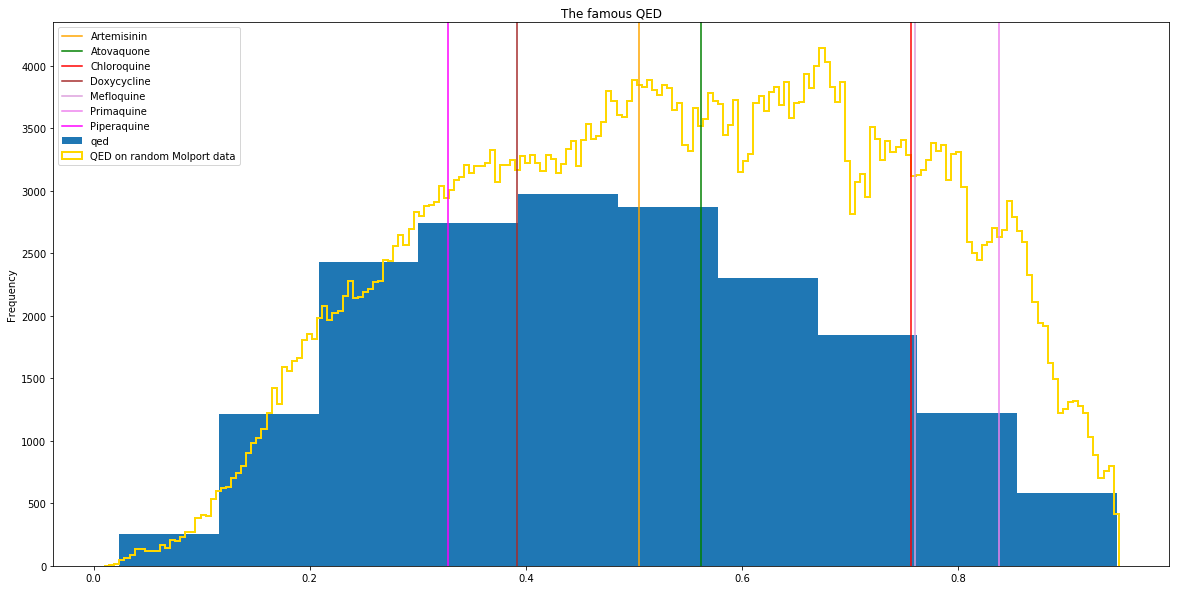

In [28]:
# Molport pickle files - we'll just chose one...
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')

mp1 = pd.read_pickle(std_files[0])

colors = ['orange', 'green', 'red', 'brown', 'plum', 'violet', 'magenta']
full_df.qed.plot.hist(title='The famous QED')
mp1.qed.name = 'QED on random Molport data'
full_df.qed.name = 'QED on MERGED Chembl data'
mp1.qed.plot.hist(histtype='step', bins=200, color='gold', lw=2)
for i in range(len(drugs)):
    plt.axvline(x=utils.get_qed(Chem.MolFromSmiles(drugs[i])), color=colors[i], label=drug_labels[i])
legend()

### 5.0 - Model extrapolation.

The ultimate goal of this paper is to demonstrate how the first steps drug discovery project should proceed, using 'what we can buy from Molport' as an initial 'idea generator'.

What we want to do in particular is to attach to our individual suggestions, and the full batch of suggestions, a 'success probability' of the batch having certain characteristics.  In particular, we want to know how good our suggestions are expected to be on 'unknown' molecules - so we need to test our model accuracy away from the data on which it was trained (extrapolation).

We'll do this in 3 steps - first using Kmeans clustering, then using potency and then using lipophilicity.  Then we'll put everything together and conclude.


### 5.1  Kmeans clustering using Tanimoto distance.

Kmeans is designed for Euclidean distance.  But maybe that doesn't matter?  Let's have a look at the correlation between the distance matrix using Euclidean and Tanimoto...

In [3]:
from scipy.spatial.distance import cdist, pdist

In [14]:
full_df.shape

(18425, 5)

In [17]:
full_df.head()

,POTENCY,fps,hfps,crippen,qed
SMILESIS,,,,,
BrC(Br)(Br)c1ncc(-c2ccccc2)cn1,7.100000,"[False, False, False, False, False, True, Fals...","[0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, ...",4.4386,0.654222
Brc1cc(Br)c2c(-c3ccccc3)n(-c3ccccc3)nc(-c3ccccc3)c1-2,6.120000,"[False, False, False, False, False, True, Fals...","[0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...",7.8361,0.244962
Brc1cc(Br)c2c(c1)C(NCCCNC1CCNc3c(Br)cc(Br)cc31)CCN2,6.082395,"[True, False, False, True, False, False, False...","[2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, ...",6.7195,0.262244
Brc1cc(Br)c2c(c1)C(NCCCNc1nc3ncccc3[nH]1)CCN2,6.227790,"[True, False, False, True, False, False, False...","[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, ...",4.4314,0.393160
Brc1cc(CNCCCNc2nc3ccccc3[nH]2)sc1Br,6.658045,"[True, False, False, True, False, False, False...","[2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",4.7412,0.461894


In [29]:
shfl_idcs = np.arange(full_df.shape[0])
np.random.shuffle(shfl_idcs)

In [31]:
da = np.asarray([x for x in full_df.iloc[list(shfl_idcs[:1000])].fps.values])
db = np.asarray([x for x in full_df.iloc[list(shfl_idcs[1000:2000])].fps.values])

In [34]:
x = cdist(da, db)

In [36]:
y = cdist(da, db, metric='jaccard')

In [40]:
stats.regress(y.ravel(), [x.ravel(),])

Coeffs:       0.1034 
R-squared:    0.2708


Let's do kmedioids in Tanimoto distance...

This code is from:

Bauckhage C. Numpy/scipy Recipes for Data Science: k-Medoids Clustering[R]. Technical Report, University of Bonn, 2015.

Please cite the article if the code is used in your research.


In [41]:
from malaria import kmedioids

In [42]:
from sklearn.metrics.pairwise import pairwise_distances

In [44]:
#data = np.asarray([x for x in full_df.fps.values]
D = pairwise_distances(np.asarray([x for x in full_df.fps.values]), metric='jaccard')

In [50]:
data = np.asarray([x for x in full_df.fps.values])
# split into 2 clusters
M, C = kmedioids.kMedoids(D, 2)

print('medoids:')
#for point_idx in M:
#    print( data[point_idx] )

print('')
print('clustering result:')
#for label in C:
#    for point_idx in C[label]:
        #print('label {0}:　{1}'.format(label, data[point_idx]))

medoids:

clustering result:


In [53]:
M

array([ 539, 9191])

In [58]:
C[0][:10]

array([ 2,  3,  6,  7,  8, 13, 16, 21, 24, 25])

In [59]:
C[1][:10]

array([ 0,  1,  4,  5,  9, 10, 11, 12, 14, 15])

In [61]:
D = None # save memory...
da = np.asarray([x for x in full_df.iloc[C[0]].fps.values])
db = np.asarray([x for x in full_df.iloc[C[1]].fps.values])
D = cdist(da, db, metric='jaccard')

In [62]:
D.shape

(8639, 9786)

In [63]:
np.min(D)

0.020408163265306121

In [65]:
np.mean(D)

0.71467127846612954

In [66]:
D.ravel()[np.argsort(D.ravel())][:10]

array([ 0.02040816,  0.03448276,  0.03571429,  0.03571429,  0.03571429,
        0.03571429,  0.03703704,  0.03773585,  0.04      ,  0.04      ])

In [68]:
# So this is the various percentile differences after clustering
np.percentile(D, [0, 10, 20, 50, 80, 100])

array([ 0.02040816,  0.63013699,  0.66129032,  0.71666667,  0.7704918 ,  1.        ])

In [70]:
# And they are slightly further away than random...
np.percentile(y, [0, 10, 20, 50, 80, 100])

array([ 0.        ,  0.62337662,  0.65517241,  0.71212121,  0.76623377,  1.        ])

I'm somewhat curious to see how many 'totally different molecules we have in our sample'...

In [71]:
(D == 1).nonzero()

(array([  35,   35,   35, ..., 8580, 8580, 8580]),
 array([ 365,  465, 1282, ..., 1469, 1638, 1639]))

In [72]:
len((D == 1).nonzero()[0])

10084

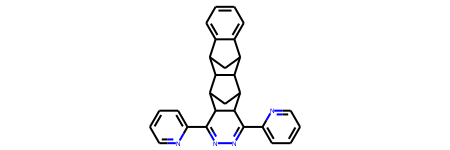

In [113]:
Chem.MolFromSmiles(full_df.iloc[C[0][8580]].name)

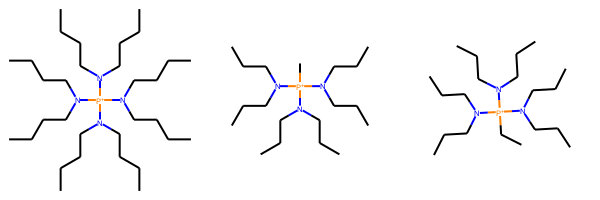

In [130]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(b[0]) for b in full_df.iloc[C[1][x]].iterrows()])

We're going to do this a different way...  

First of all - remember that we are dealing with an extremely biased dataset.  It's unclear whether the variance of our activity is over or under-stated.  Only 'actives' (or at least a preponderance of actives) have been reported.  This would cause variance to be understated (since we're missing small values).  However - we know most molecules _aren't_ active, so the variance on inactive molecules is presumably less than the variance on active ones - which would cause the variance to be overstated.  Since we don't have a genuinely good way to fix this problem at this point, we're going to just ignore it and assume the variance is a reasonable estimate...

What is the standard deviation across our whole dataset?

In [132]:
np.std(full_df.POTENCY.values, ddof=1)

0.4614266160004088

OK - so that's great.  Now, we going to compute the sample standard deviations as a function of Tanimoto distance.  We'll start with the easiest one - 0...

So we're going to have a bunch of samples of different sizes.  I _think_ it's OK to say that the global estimate of the standard deviation is the weighted mean of the different sample estimates, weighted by the sample size (hopefully an actual statistical **JAMES** can confirm this).

In [137]:
fpa = np.asarray([x for x in full_df.fps.values])

In [142]:
import pdb

In [146]:
fpa = np.asarray([x for x in full_df.fps.values])

estimates = []
weights = []

for i in range(full_df.shape[0]):
    v = [full_df.POTENCY.values[i]]
    dists = cdist(np.asarray([full_df.fps.values[i],]), fpa)[0]
    dists[i]+=1
    gpot = full_df.POTENCY.values[dists == 0]
    if len(gpot) == 0:
        continue
    #pdb.set_trace()
    gpot = np.concatenate((v, gpot))
    estimates.append(np.std(gpot, ddof=1))
    weights.append(gpot.shape[0]-1)
    pass

OK - so this is a really important result.  The standard deviation of the potency values for malaria of two compounds with identical 128-bit fingerprints is 0.185 (and we have 665 effective datapoints for this estimate, accounting for double-counting)

In [151]:
np.sum(weights)/2

665

In [152]:
np.average(estimates, weights=weights)

0.18547647882731794

This means that the 128-bit fingerprint captures 84% of the variance in potency (which is decent!)

In [154]:
1-np.average(estimates, weights=weights)**2/np.std(full_df.POTENCY.values, ddof=1)**2

0.83842565606830988

What we actually want here is a plot showing the sensitivity of sigma to Tanimoto distance.  So let's construct that...

In [163]:
estimates_hdr = {}
weight_hdr = {}
ctr_hdr = {}

bins = [-0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(bins)-1):
    estimates_hdr[i] = []
    weight_hdr[i] = []
    ctr_hdr[i] = []
    pass

for i in range(full_df.shape[0]):
    v = [full_df.POTENCY.values[i]]
    dists = cdist(np.asarray([full_df.fps.values[i],]), fpa, metric='jaccard')[0]
    dists[i]+=2 # to exclude from anything
    
    for j in range(len(bins)-1):
        bstart = bins[j]
        bend = bins[j+1]
        gd = (dists > bstart) & (dists <= bend)
        gpot = full_df.POTENCY.values[gd]
        if len(gpot) == 0:
            continue

        gpot = np.concatenate((v, gpot))
        estimates_hdr[j].append(np.std(gpot, ddof=1))
        weight_hdr[j].append(gpot.shape[0]-1)
        ctr_hdr[j].append(np.mean(dists[gd]))
        pass
    pass                                    

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal


In [165]:
ctrs = np.asarray([np.average(ctr_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])

In [166]:
sigmas = np.asarray([np.average(estimates_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])

In [169]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [170]:
figsize(20, 10)

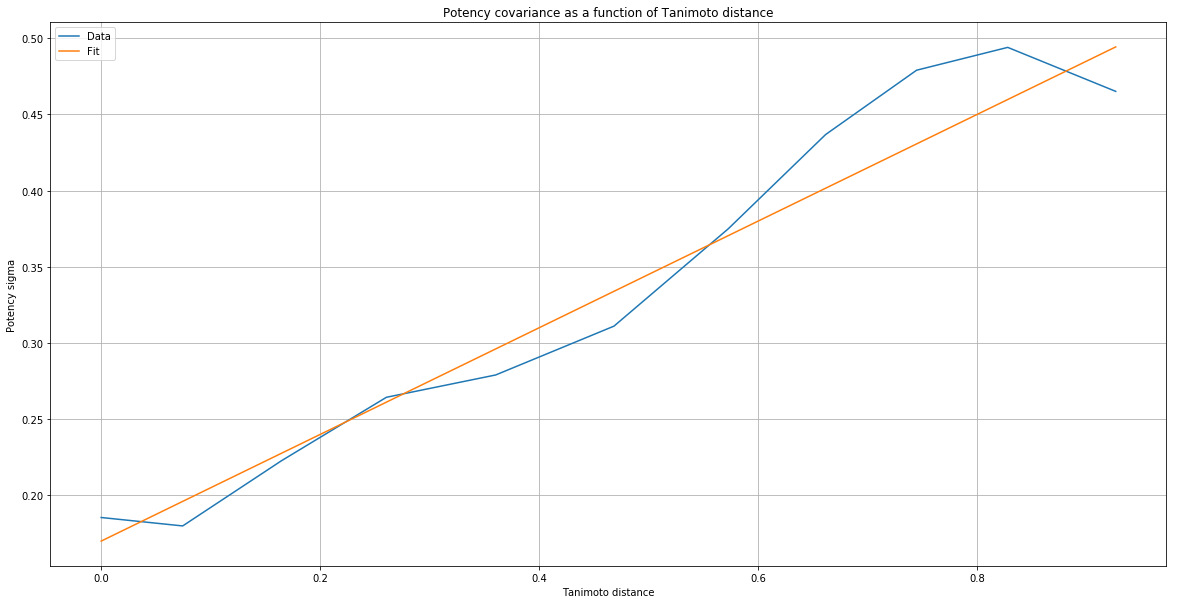

In [299]:
plt.plot(ctrs, sigmas, label='Data'); grid(True); xlabel('Tanimoto distance'); ylabel('Potency sigma')
plt.plot(ctrs, 0.17+0.35*ctrs, label='Fit')
legend(loc='best')
_ = title('Potency covariance as a function of Tanimoto distance')
savefig('figures/covariance.png')

Now we just need to do the following - look at R^2 as a function of Tanimoto distance...  We go through the data for each datapoint fitting a random forest and linear model, and look at r^2...

In [189]:
fc_rf_hdr = {}
fc_lr_hdr = {}
ctr_hdr = {}  # this tells you the mean distance...

bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.9]

md = stats.get_model_dict()

for i in range(len(bins)):
    fc_rf_hdr[i] = []
    fc_lr_hdr[i] = []
    ctr_hdr[i] = []
    pass

for i in range(full_df.shape[0]):

    if i < 10:
        print ('Doing', i)
        print(datetime.datetime.now().time())
    elif i < 100:
        if (i % 10) == 0:
            print ('Doing', i)
            print(datetime.datetime.now().time())
    else:
        if (i % 100) == 0:
            print ('Doing', i)
            print(datetime.datetime.now().time()) 
            
    my_fp = np.asarray([full_df.fps.values[i],])
    dists = cdist(my_fp, fpa, metric='jaccard')[0]
    dists[i]-=2 # to exclude from anything (we're going to use >)
    
    for j in range(len(bins)):
        bstart = bins[j]

        gd = (dists >= bstart) 

        prd_i_rf = md['rf']['m'](**md['rf']['kw']).fit(fpa[gd], 
                full_df.POTENCY.values[gd]).predict(my_fp)
        
        prd_i_rdg = md['ridge']['m'](**md['ridge']['kw']).fit(fpa[gd], 
                full_df.POTENCY.values[gd]).predict(my_fp)
    
        fc_rf_hdr[j].append(prd_i_rf[0])
        fc_lr_hdr[j].append(prd_i_rdg[0])

        ctr_hdr[j].append(np.mean(dists[gd]))
        pass
    pass   

('Doing', 0)
08:42:18.510482
('Doing', 1)
08:42:42.581894
('Doing', 2)
08:43:05.701282
('Doing', 3)
08:43:28.357659
('Doing', 4)
08:43:49.257890
('Doing', 5)
08:44:11.128248
('Doing', 6)
08:44:32.870427
('Doing', 7)
08:44:55.300760
('Doing', 8)
08:45:18.051444
('Doing', 9)
08:45:40.497581
('Doing', 10)
08:46:03.092037
('Doing', 20)
08:49:49.507639
('Doing', 30)
08:53:29.177370
('Doing', 40)
08:56:57.571691
('Doing', 50)
09:00:35.284636
('Doing', 60)
09:04:13.690561
('Doing', 70)
09:07:50.350542
('Doing', 80)
09:11:29.429786
('Doing', 90)
09:15:10.350927
('Doing', 100)
09:18:45.577916
('Doing', 200)
09:54:14.191948
('Doing', 300)
10:29:43.906160
('Doing', 400)
11:05:32.968110
('Doing', 500)
11:41:06.110070
('Doing', 600)
12:15:21.966135
('Doing', 700)
12:49:45.809457
('Doing', 800)
13:24:28.758897
('Doing', 900)
13:59:12.999507
('Doing', 1000)
14:33:22.797633
('Doing', 1100)
15:07:54.041350
('Doing', 1200)
15:41:58.971951
('Doing', 1300)
16:15:27.396457
('Doing', 1400)
16:49:55.719816
(

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal


('Doing', 15000)
00:48:46.304045
('Doing', 15100)
01:23:20.213476
('Doing', 15200)
01:58:13.120091
('Doing', 15300)
02:33:54.641171
('Doing', 15400)
03:09:31.592886
('Doing', 15500)
03:44:25.985892
('Doing', 15600)
04:19:49.451694
('Doing', 15700)
04:54:47.018736
('Doing', 15800)
05:29:25.093425
('Doing', 15900)
06:03:40.734392
('Doing', 16000)
06:38:20.479036
('Doing', 16100)
07:13:29.029977
('Doing', 16200)
07:48:27.932832
('Doing', 16300)
08:23:42.930755
('Doing', 16400)
08:59:25.742724
('Doing', 16500)
09:36:51.861847
('Doing', 16600)
10:12:39.690915
('Doing', 16700)
10:47:37.595905
('Doing', 16800)
11:22:17.113854
('Doing', 16900)
11:57:27.036909
('Doing', 17000)
12:34:32.253746
('Doing', 17100)
13:10:56.079310
('Doing', 17200)
13:47:59.855955
('Doing', 17300)
14:25:02.629715
('Doing', 17400)
15:01:36.662345
('Doing', 17500)
15:38:51.652918
('Doing', 17600)
16:15:51.384041
('Doing', 17700)
16:52:22.036495
('Doing', 17800)
17:29:02.667054
('Doing', 17900)
18:05:33.236669
('Doing', 

In [290]:
#joblib.dump(fc_rf_hdr, 'modelling/rf_fc_results')
#joblib.dump(fc_lr_hdr, 'modelling/rdg_fc_results')
#joblib.dump(ctr_hdr, 'modelling/ctr_results')

In [225]:
def rank(x):
    return np.argsort(np.argsort(x))/(len(x) + 0.) - 0.5

In [293]:
result_hdr = {'rf' : [], 'rdg' : [], 'rfrk' : [], 'rdgrk' : [], 
             'rfb' : [], 'rdgb' : [], 'rfrkb' : [], 'rdgrkb' : [], 
             }

In [294]:
for i in range(7):
    rf_beta, rf_r2 = stats.regress(full_df.POTENCY.values, [fc_rf_hdr[i],], do_print=False, one=True)
    rdg_beta, rdg_r2 = stats.regress(full_df.POTENCY.values, [fc_lr_hdr[i],], do_print=False, one=True)
    rfr_beta, rfr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_rf_hdr[i]),], 
                                     do_print=False)
    rdgr_beta, rdgr_r2 = stats.regress(rank(full_df.POTENCY.values), [rank(fc_lr_hdr[i]),], 
                                       do_print=False)   
    
    result_hdr['rf'].append(rf_r2)
    result_hdr['rfb'].append(rf_beta[0])
    result_hdr['rdg'].append(rdg_r2)
    result_hdr['rdgb'].append(rdg_beta[0])
    result_hdr['rfrk'].append(rfr_r2)
    result_hdr['rfrkb'].append(rfr_beta[0])
    result_hdr['rdgrk'].append(rdgr_r2)
    result_hdr['rdgrkb'].append(rdgr_beta[0])

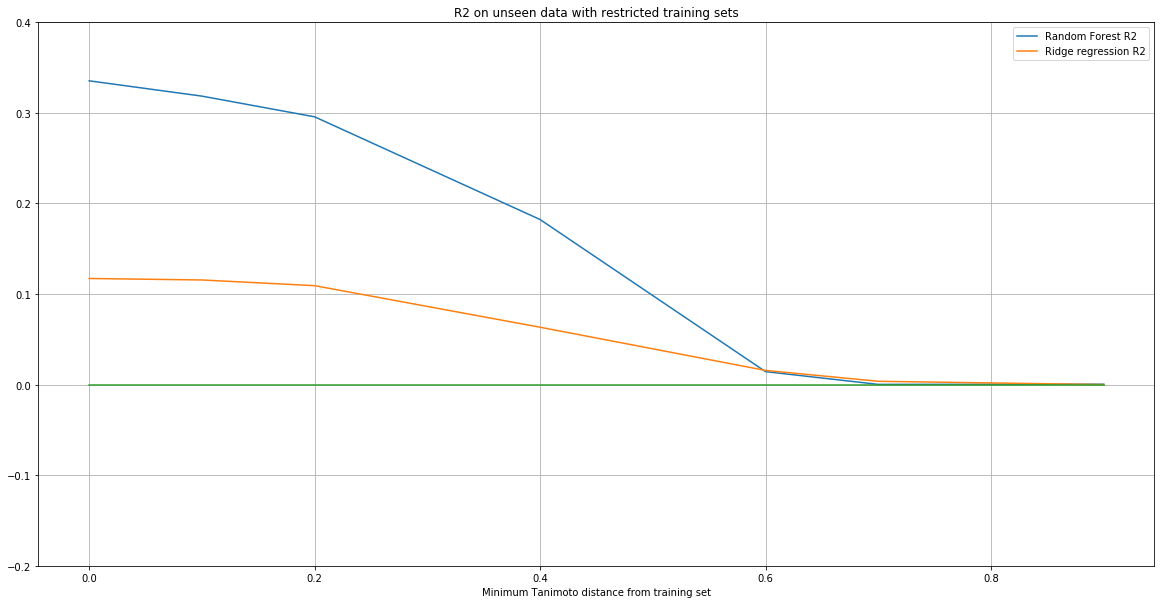

In [295]:
plot(bins, result_hdr['rf'], label='Random Forest R2')
plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plot(bins, np.zeros(7))
xlabel('Minimum Tanimoto distance from training set')
ylim((-0.2, 0.4))
grid(True); legend(loc='best')
_ = title('R2 on unseen data with restricted training sets')
savefig('figures/r2_res.png')

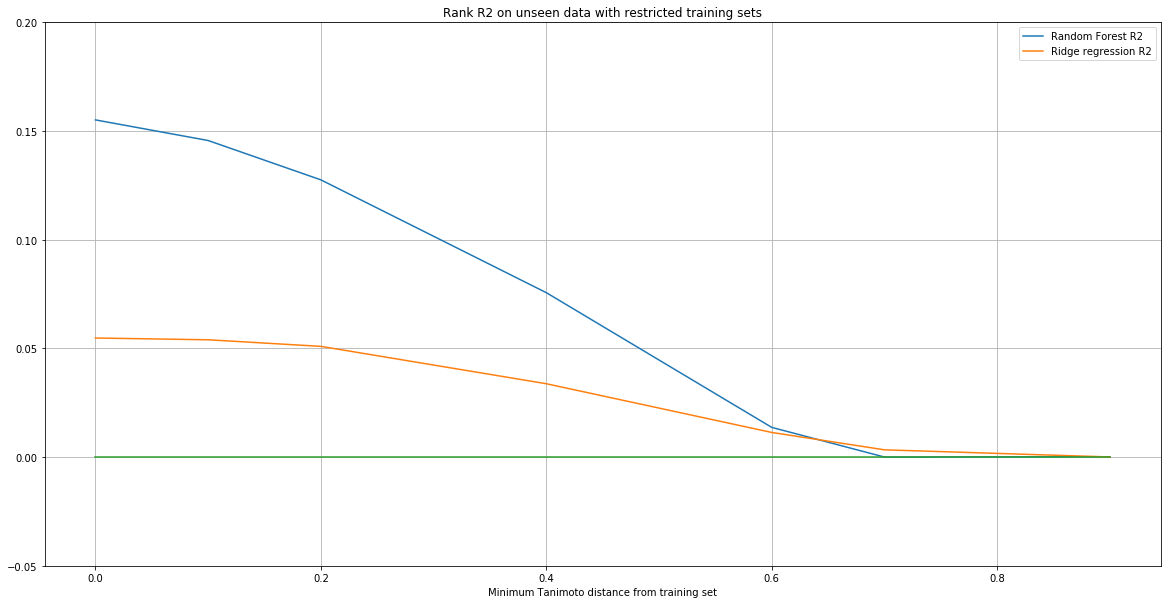

In [296]:
plot(bins, result_hdr['rfrk'], label='Random Forest R2')
plot(bins, result_hdr['rdgrk'], label='Ridge regression R2'); 
plot(bins, np.zeros(7))
xlabel('Minimum Tanimoto distance from training set')
ylim((-0.05, 0.2))
grid(True); legend(loc='best')
_ = title('Rank R2 on unseen data with restricted training sets')
savefig('figures/r2r_res.png')

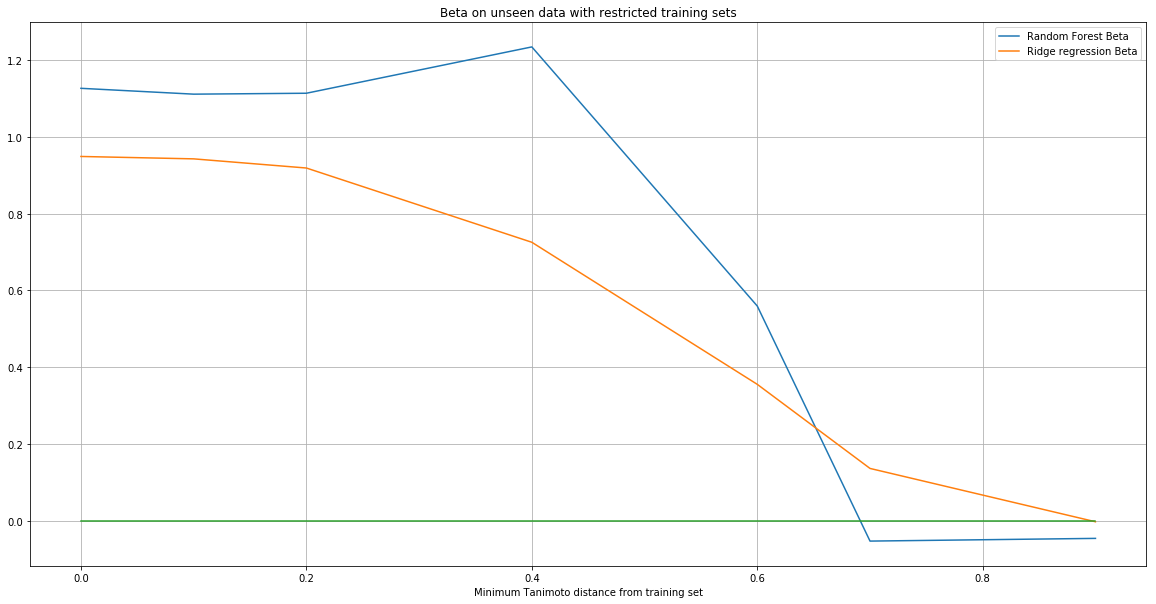

In [297]:
plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plot(bins, np.zeros(7))
xlabel('Minimum Tanimoto distance from training set')
grid(True); legend(loc='best')
_ = title('Beta on unseen data with restricted training sets')
savefig('figures/beta_res.png')

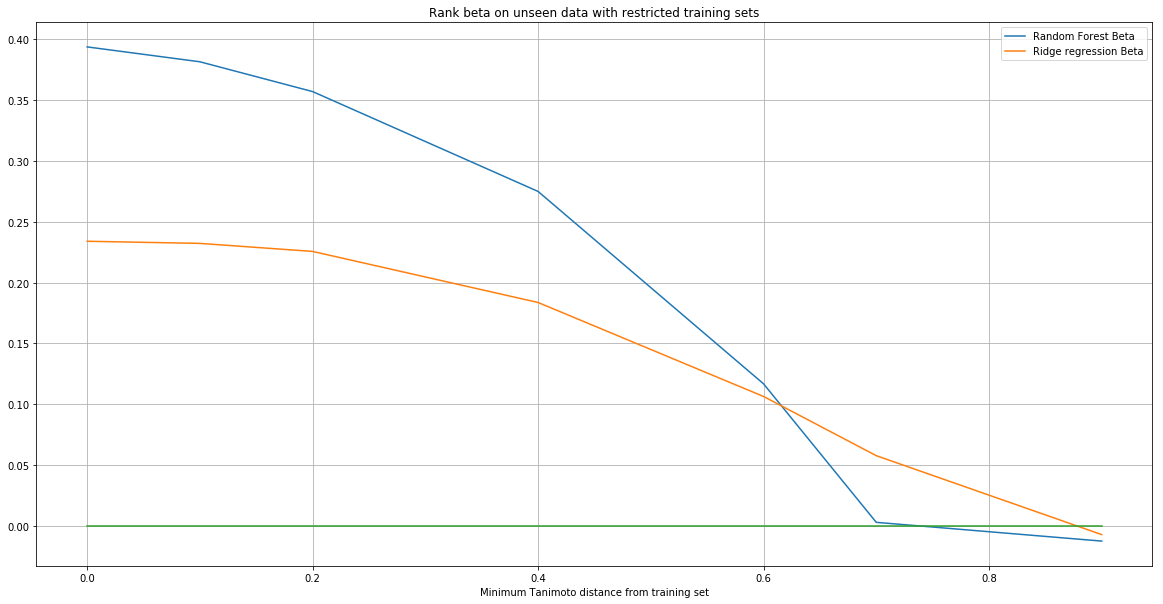

In [298]:
plot(bins, result_hdr['rfrkb'], label='Random Forest Beta')
plot(bins, result_hdr['rdgrkb'], label='Ridge regression Beta'); 
plot(bins, np.zeros(7))
xlabel('Minimum Tanimoto distance from training set')
grid(True); legend(loc='best')
_ = title('Rank beta on unseen data with restricted training sets')
savefig('figures/betar_res.png')

In [302]:
np.mean(full_df.POTENCY.values)

6.266031379402591

In [303]:
3.5 + 0.4 * 6.266

6.0064

In [305]:
from functools import partial

In [309]:
mdl = partial(np.interp, xp=np.asarray(bins), fp=np.asarray(result_hdr['rfrkb']).clip(0., 1.))

In [310]:
mdl(0.1*np.arange(10))

array([ 0.39378827,  0.38156201,  0.35706   ,  0.31601409,  0.27496818,
        0.19588762,  0.11680706,  0.00291629,  0.00145814,  0.        ])

### 5.0.  Molport suggestions...

So in this final section - we'll have some fun.  We'll also look at some of the consequences of the various things we have investigated.

(random link)
https://www.nature.com/articles/nature09107 

We'll see what compounds are suggested as being most promising from our 7.5M commercially available Molport compounds if we select according to various criteria.


First off - let's show that if we select just for potency, we get somewhat reasonable results, although we're really just picking up the things most similar to Artemisinin...

#### 5.0.  Recap of known drugs...

In [349]:
# first fit full models....
reload(stats)
full_models = stats.fit_models(df_tcams_nd, full_df)
from malaria import mp_utils

In [352]:
full_models['power']['dist'] = mdl

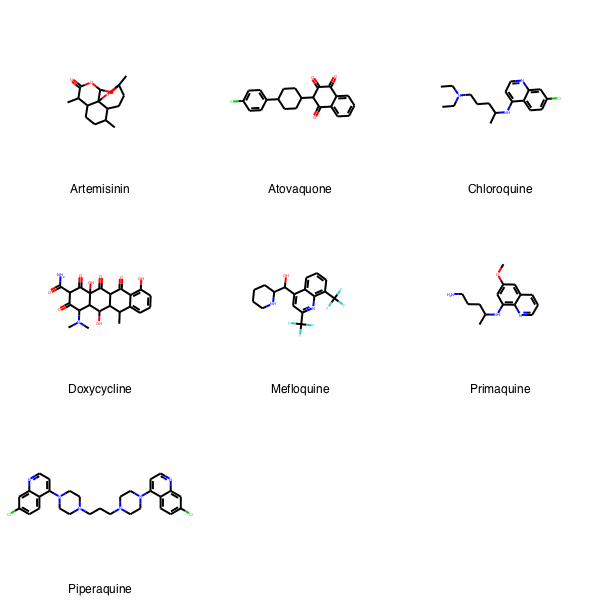

In [30]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=drug_labels)

How similar are these drugs to each other?  The only really good way we have of measuring similarity is Tanimoto similarity (or rather distance in Tanimoto space).  Here we show Tanimoto distance between the various drugs.  The limitations of Tanimoto as a distance metric are fairly visible here, since Piperaquine and Chloroquine are 0.5 distant, even though they are basically the same...

In [31]:
from scipy.spatial.distance import pdist, squareform
hdr =squareform(pdist([utils.get_fp(x) for x in df_drug.SMILESIS.values], metric='jaccard'))

mhdr = {'labels' : drug_labels}
for (i, label) in enumerate(drug_labels):
    mhdr[label] = hdr[i]
    pass
pd.DataFrame.from_dict(mhdr)[['labels', ] + drug_labels]

,labels,Artemisinin,Atovaquone,Chloroquine,Doxycycline,Mefloquine,Primaquine,Piperaquine
0,Artemisinin,0.000000,0.764706,0.766667,0.769231,0.803279,0.754386,0.842105
1,Atovaquone,0.764706,0.000000,0.745455,0.750000,0.807018,0.777778,0.780000
2,Chloroquine,0.766667,0.745455,0.000000,0.753623,0.746032,0.547170,0.500000
3,Doxycycline,0.769231,0.750000,0.753623,0.000000,0.750000,0.847222,0.800000
4,Mefloquine,0.803279,0.807018,0.746032,0.750000,0.000000,0.733333,0.732143
5,Primaquine,0.754386,0.777778,0.547170,0.847222,0.733333,0.000000,0.647059
6,Piperaquine,0.842105,0.780000,0.500000,0.800000,0.732143,0.647059,0.000000


In [374]:
from scipy.spatial.distance import cdist
def dist_df(smiles, offset=10):
    dct = {'dist_from' : drug_labels}
    for i, sm in enumerate(smiles):
        cd = cdist(np.asarray([utils.get_fp(sm),]), np.asarray([utils.get_fp(d) for d in drugs]), metric='jaccard')
        dct['mol_' + str(i)] = cd[0]
        pass
    return pd.DataFrame.from_dict(dct)

def dist_full(smiles, offset=10):
    dct = {}
    for i, sm in enumerate(smiles):
        cd = cdist(np.asarray([utils.get_fp(sm),]), np.asarray([x for x in full_df.fps.values]), metric='jaccard')[0]
        smallest = cd[np.argsort(cd)]
        dct['mol_' + str(i)] = smallest[:10]
        pass
    return pd.DataFrame.from_dict(dct)

def self_dist(smiles):
    return squareform(pdist(np.asarray([utils.get_fp(sm) for sm in smiles]), metric='jaccard'))

### 3.1  10 Most potent drugs...

P = predicted potency (average RF and Ridge prediction)
L = LogP
T = predicted toxicity
Q = QED

In [312]:
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')

In [333]:
mp1_fps = None

In [323]:
min_dist = np.ones(mp1.shape[0])
mp1_fps = np.asarray([x for x in mp1.fps.values])
blk = []

for i in range(1, full_df.shape[0], 1000):
    e = min(i+1000, full_df.shape)
    blk.append(np.asarray([x for x in full_df.fps.values[i:e]]))
    pass

In [339]:
def add_min_dist(fn):
    mp_df = pd.read_pickle(fn)
    
    mins = np.ones(mp_df.shape[0], dtype=float)
    mp1_fps = np.asarray([x for x in mp_df.fps.values])
    
    for bl in blk:
        bl_min = np.min(cdist(bl, mp1_fps, metric='jaccard'), axis=0)
        mins = np.minimum(mins, bl_min)
    
    md = pd.Series(mins, index=mp_df.index)
    mp_df['min_dist'] = md
    mp_df.to_pickle(fn)

In [346]:
for fn in std_files[1:]:
    add_min_dist(fn)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in minimum
  if __name__ == '__main__':


In [342]:
mp_df = pd.read_pickle(std_files[0])

In [344]:
mp_df.min_dist.values[:40]

array([ 0.42857143,  0.5       ,  0.48780488,  0.63157895,  0.60606061,
        0.48148148,  0.58536585,  0.58928571,  0.48484848,  0.2962963 ,
        0.59259259,  0.62962963,  0.64516129,  0.67647059,  0.53488372,
        0.59459459,  0.46428571,  0.52380952,  0.5       ,  0.53333333,
        0.57142857,  0.        ,  0.64516129,  0.57142857,  0.64864865,
        0.56097561,  0.62857143,  0.61290323,  0.53488372,  0.54285714,
        0.52777778,  0.36666667,  0.52941176,  0.53333333,  0.57142857,
        0.32      ,  0.67741935,  0.55172414,  0.58974359,  0.63157895])

In [345]:
mp_df = None

In [356]:
#reload(mp_utils)
#mp_utils.get_best(full_models, drugs=drugs)

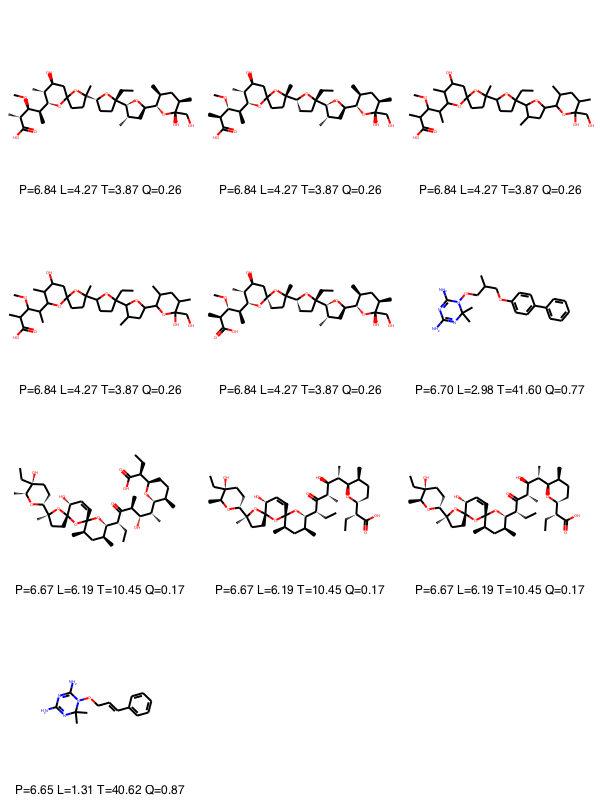

In [357]:
mp_utils.summarize('POT', 10)

One (of several) problems with just chosing the most potent predicted drugs is that (as one can see by eye) - they are all quite close to Artemisinin.  Below we show the table of tanimoto distances between these chosen molecules and our top drugs:

In [360]:
sm, labels = mp_utils.summarize('POT', 10, draw=False)
dist_df(sm)

,dist_from,mol_0,mol_1,mol_2,mol_3,mol_4,mol_5,mol_6,mol_7,mol_8,mol_9
0,Artemisinin,0.718310,0.718310,0.718310,0.718310,0.718310,0.758621,0.684932,0.684932,0.684932,0.807018
1,Atovaquone,0.735294,0.735294,0.735294,0.735294,0.735294,0.759259,0.786667,0.786667,0.786667,0.788462
2,Chloroquine,0.756410,0.756410,0.756410,0.756410,0.756410,0.607143,0.692308,0.692308,0.692308,0.654545
3,Doxycycline,0.728395,0.728395,0.728395,0.728395,0.728395,0.800000,0.698795,0.698795,0.698795,0.805970
4,Mefloquine,0.829268,0.829268,0.829268,0.829268,0.829268,0.758065,0.753086,0.753086,0.753086,0.783333
5,Primaquine,0.794872,0.794872,0.794872,0.794872,0.794872,0.636364,0.746835,0.746835,0.746835,0.709091
6,Piperaquine,0.873418,0.873418,0.873418,0.873418,0.873418,0.679245,0.763158,0.763158,0.763158,0.730769


If we optimize for potency - logP, our results are dominated by natural products with very high negative logP...  We just show the top 3 for interest... (and because these molecules are quite pretty).

#### Select for Potency - logP

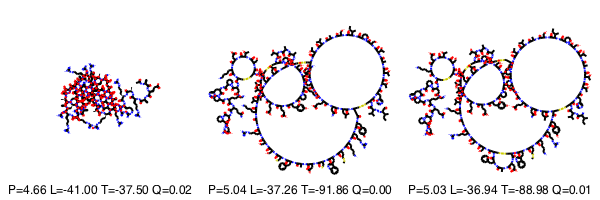

In [361]:
mp_utils.summarize('LIP', 3)

Clearly we don't want to weight logP on the same level as predicted potency... And - if you examine the logP numbers, you will see that even optimizing for potency - logP/12 will give the same crazy molecules back.  The conditioning function for logP needs to taper off at low (negative) values.

We looked at just using some reasonable thresholds on toxicity and logP, but the ones we had selected for potency already satisfied these.

However - if we impose a QED threshold of 0.5, then we do find all the various Artemisinin in the molport database, but also some interesting looking related compounds...  This does seem to show that QED does play a valuable screening role.  Again though - we're getting things that are much too similar to existing drugs (Artemisinin in particular)

### Best on Potency, with QED>0.5, LogP<4, predicted(Tox) < 25%

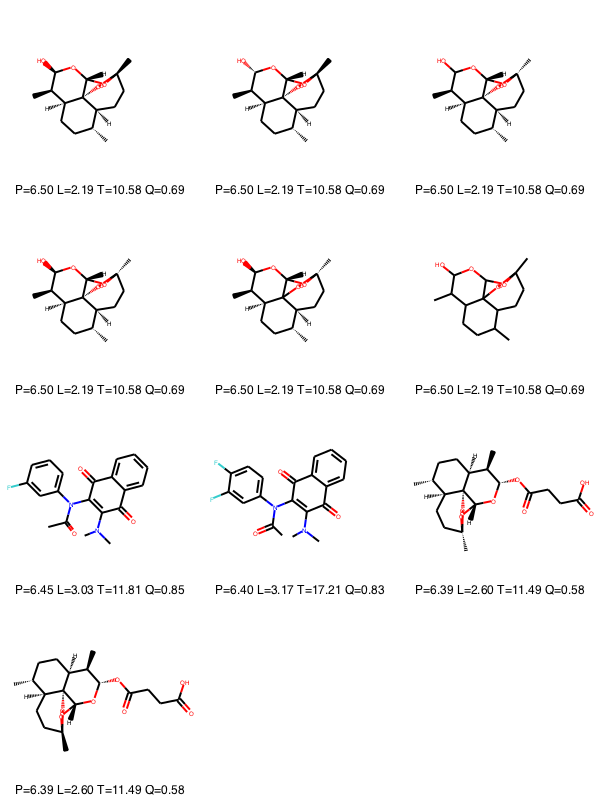

In [362]:
mp_utils.summarize('BEST_Q', 10)

In [363]:
sm, labels = mp_utils.summarize('BEST_Q', 10, draw=False)
dist_df(sm)

,dist_from,mol_0,mol_1,mol_2,mol_3,mol_4,mol_5,mol_6,mol_7,mol_8,mol_9
0,Artemisinin,0.404762,0.404762,0.404762,0.404762,0.404762,0.404762,0.816667,0.821429,0.519231,0.519231
1,Atovaquone,0.760000,0.760000,0.760000,0.760000,0.760000,0.760000,0.625000,0.613636,0.758621,0.758621
2,Chloroquine,0.762712,0.762712,0.762712,0.762712,0.762712,0.762712,0.737705,0.736842,0.761194,0.761194
3,Doxycycline,0.784615,0.784615,0.784615,0.784615,0.784615,0.784615,0.661290,0.677966,0.797297,0.797297
4,Mefloquine,0.736842,0.736842,0.736842,0.736842,0.736842,0.736842,0.711864,0.732143,0.776119,0.776119
5,Primaquine,0.793103,0.793103,0.793103,0.793103,0.793103,0.793103,0.786885,0.767857,0.769231,0.769231
6,Piperaquine,0.839286,0.839286,0.839286,0.839286,0.839286,0.839286,0.698113,0.693878,0.790323,0.790323


### Final selection.

Finally we'll put it all together and look for what we would really care about:  drugs that are predicted potent, logP between 2 and 4, QED > 0.5, tox < 0.2, Tanimoto distance from any existing drug > 0.6, minimum distance from anything in the Chembl malaria dataset > 0.1, and oh yes - and don't forget cheap to buy!

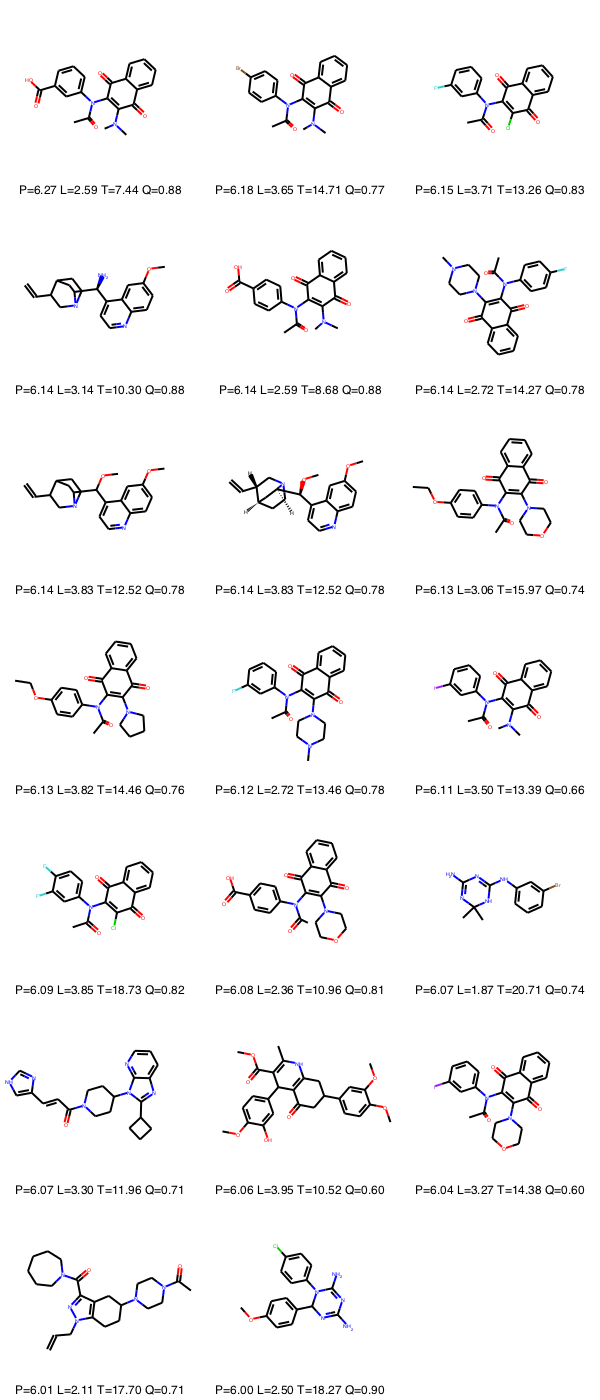

In [364]:
mp_utils.summarize('BEST_D', 20, check_new=full_df)

Let's check for distance to existing drugs...

In [365]:
sms, lbls = mp_utils.summarize('BEST_D', 20, draw=False, check_new=full_df)

In [366]:
dist_df(sms[:10])

,dist_from,mol_0,mol_1,mol_2,mol_3,mol_4,mol_5,mol_6,mol_7,mol_8,mol_9
0,Artemisinin,0.836066,0.818182,0.854839,0.769231,0.821429,0.870968,0.769231,0.769231,0.806452,0.838710
1,Atovaquone,0.625000,0.604651,0.625000,0.809524,0.613636,0.673469,0.770492,0.770492,0.647059,0.660000
2,Chloroquine,0.758065,0.754386,0.716667,0.676923,0.758621,0.793651,0.656250,0.656250,0.769231,0.781250
3,Doxycycline,0.703125,0.737705,0.703125,0.739726,0.721311,0.698413,0.739726,0.739726,0.696970,0.727273
4,Mefloquine,0.711864,0.771930,0.711864,0.606557,0.754386,0.750000,0.606557,0.606557,0.784615,0.777778
5,Primaquine,0.786885,0.763636,0.786885,0.616667,0.789474,0.803279,0.616667,0.616667,0.737705,0.728814
6,Piperaquine,0.698113,0.687500,0.698113,0.721311,0.720000,0.716981,0.677966,0.677966,0.714286,0.703704


In [367]:
dist_df(sms[10:], offset=10)

,dist_from,mol_0,mol_1,mol_2,mol_3,mol_4,mol_5,mol_6,mol_7,mol_8,mol_9
0,Artemisinin,0.859375,0.763636,0.862069,0.833333,0.854545,0.791045,0.758065,0.779661,0.725806,0.767857
1,Atovaquone,0.692308,0.630435,0.613636,0.673469,0.791667,0.812500,0.690909,0.686275,0.825397,0.693878
2,Chloroquine,0.803030,0.724138,0.714286,0.812500,0.620000,0.757143,0.723077,0.781250,0.712121,0.660714
3,Doxycycline,0.671875,0.688525,0.721311,0.698413,0.790323,0.652174,0.671642,0.666667,0.681159,0.772727
4,Mefloquine,0.741935,0.719298,0.732143,0.770492,0.740741,0.676923,0.757576,0.737705,0.782609,0.806452
5,Primaquine,0.812500,0.754386,0.767857,0.841270,0.653061,0.800000,0.730159,0.809524,0.794118,0.641509
6,Piperaquine,0.709091,0.653061,0.693878,0.740741,0.673913,0.746032,0.728814,0.679245,0.737705,0.711538


Let's check how novel these predictions are - by comparing them to anything in the Chembl data...

In [368]:
dist_full(sms[:10])

,mol_0,mol_1,mol_2,mol_3,mol_4,mol_5,mol_6,mol_7,mol_8,mol_9
0,0.105263,0.151515,0.150000,0.108696,0.176471,0.153846,0.108696,0.108696,0.113636,0.121951
1,0.243902,0.200000,0.282609,0.108696,0.222222,0.153846,0.108696,0.108696,0.162791,0.139535
2,0.275000,0.222222,0.282609,0.108696,0.236842,0.175000,0.108696,0.108696,0.238095,0.225000
3,0.279070,0.222222,0.288889,0.108696,0.243243,0.243902,0.108696,0.108696,0.255319,0.239130
4,0.282051,0.263158,0.304348,0.108696,0.243243,0.250000,0.108696,0.108696,0.255814,0.279070
5,0.292683,0.263158,0.317073,0.240741,0.282051,0.261905,0.137255,0.137255,0.268293,0.279070
6,0.325581,0.263158,0.325581,0.285714,0.282051,0.272727,0.210526,0.210526,0.288889,0.279070
7,0.333333,0.263158,0.333333,0.288462,0.317073,0.275000,0.214286,0.214286,0.288889,0.292683
8,0.395833,0.300000,0.363636,0.288462,0.365854,0.285714,0.241379,0.241379,0.288889,0.295455
9,0.425532,0.333333,0.363636,0.288462,0.390244,0.295455,0.272727,0.272727,0.297872,0.304348


In [369]:
dist_full(sms[10:])

,mol_0,mol_1,mol_2,mol_3,mol_4,mol_5,mol_6,mol_7,mol_8,mol_9
0,0.119048,0.184211,0.171429,0.131579,0.161290,0.134615,0.111111,0.153846,0.108696,0.135135
1,0.139535,0.184211,0.275000,0.157895,0.281250,0.355932,0.148936,0.186047,0.448276,0.243902
2,0.159091,0.216216,0.277778,0.219512,0.314286,0.426230,0.183673,0.214286,0.508772,0.375000
3,0.232558,0.222222,0.282051,0.219512,0.323529,0.482759,0.200000,0.214286,0.515625,0.410256
4,0.255814,0.225000,0.289474,0.219512,0.475000,0.483871,0.204082,0.219512,0.523077,0.418605
5,0.295455,0.230769,0.300000,0.236842,0.500000,0.491525,0.204082,0.227273,0.523077,0.463415
6,0.295455,0.236842,0.317073,0.272727,0.500000,0.500000,0.215686,0.255814,0.523810,0.465116
7,0.295455,0.282051,0.317073,0.272727,0.513514,0.507463,0.220000,0.266667,0.531250,0.500000
8,0.304348,0.355556,0.325000,0.272727,0.522727,0.507463,0.220000,0.275000,0.534483,0.511111
9,0.311111,0.380952,0.333333,0.285714,0.525000,0.507463,0.220000,0.309524,0.536232,0.511628


This is pretty good - these are genuinely fairly novel predictions - minimum Tanimoto distance to anything we have really seen is > 0.4...

Finally - how much could we buy these molecules for?  Labels below in $/MG...

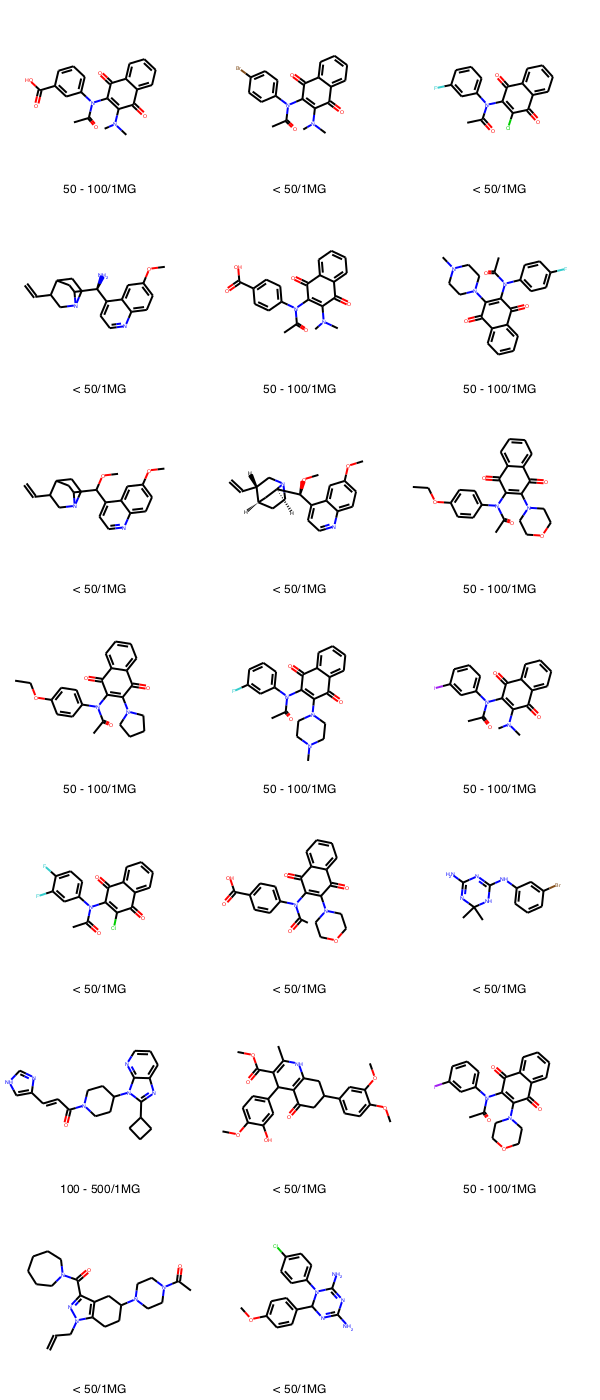

In [370]:
mp_utils.summarize('BEST_D', 20, check_new=full_df, plabel=True)

###  Final section - use optimization to choose 'different' ones...

In [371]:
from scipy.spatial.distance import squareform

In [378]:
# Not too bad - could be improved probably...
self_dist(sms[:10])

array([[ 0.        ,  0.25641026,  0.39130435,  0.79710145,  0.18421053,
         0.51020408,  0.77941176,  0.77941176,  0.51923077,  0.52941176],
       [ 0.25641026,  0.        ,  0.41860465,  0.81538462,  0.14705882,
         0.44186047,  0.796875  ,  0.796875  ,  0.45652174,  0.46666667],
       [ 0.39130435,  0.41860465,  0.        ,  0.79710145,  0.43181818,
         0.41304348,  0.76119403,  0.76119403,  0.49019608,  0.5       ],
       [ 0.79710145,  0.81538462,  0.79710145,  0.        ,  0.8358209 ,
         0.82857143,  0.19607843,  0.19607843,  0.73529412,  0.72727273],
       [ 0.18421053,  0.14705882,  0.43181818,  0.8358209 ,  0.        ,
         0.45454545,  0.8       ,  0.8       ,  0.46808511,  0.47826087],
       [ 0.51020408,  0.44186047,  0.41304348,  0.82857143,  0.45454545,
         0.        ,  0.8115942 ,  0.8115942 ,  0.41666667,  0.39130435],
       [ 0.77941176,  0.796875  ,  0.76119403,  0.19607843,  0.8       ,
         0.8115942 ,  0.        ,  0.        